Comparison: Year 2015, Old: 202007F New:202007H

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
year = '2015'
olddir = '202007/202007F/'
newdir = '202007/202007H/'

In [4]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=False, olddir=olddir, d201905=False, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
            f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(olddir)
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(newdir)
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [5]:
def profiles(tracers, file, olddir=olddir, d201905=False, dosum=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    ds.close()
    dm.close()

    
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    return fig

In [6]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, d201905=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][0])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

## January: Temperature

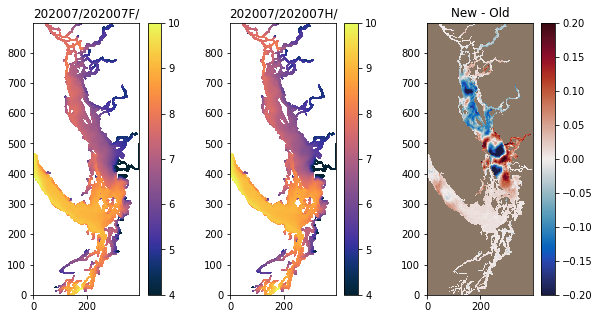

In [56]:
tracer = 'votemper'
file = 'grid'
month = '01'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 4
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

9.569403334237107 9.575480392228943


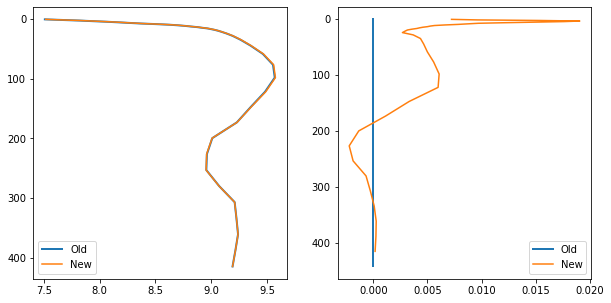

In [8]:
fig = profiles(tracer, file)

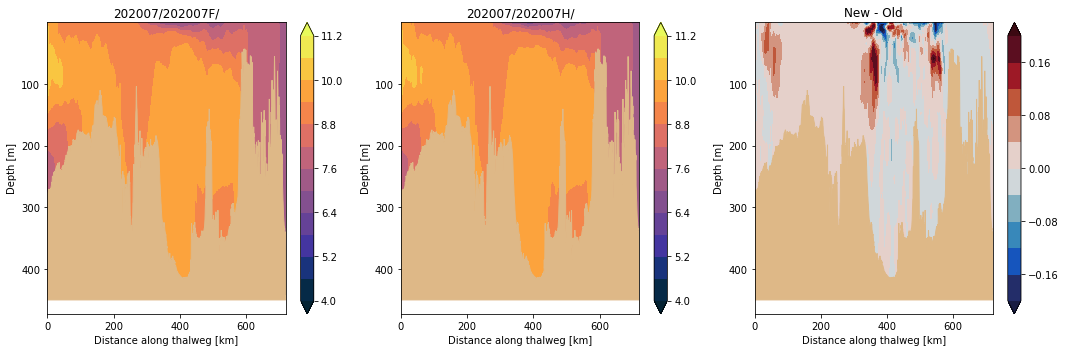

In [9]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Salinity

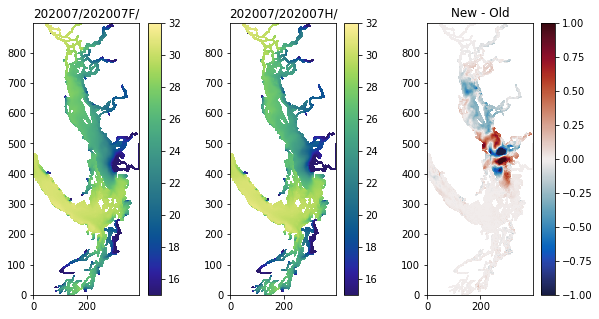

In [10]:
tracer = 'vosaline'
file = 'grid'
month = '01'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

31.678839660254575 31.676685483879886


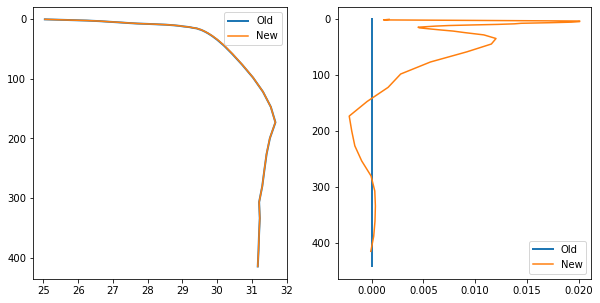

In [11]:
fig = profiles(tracer, file)

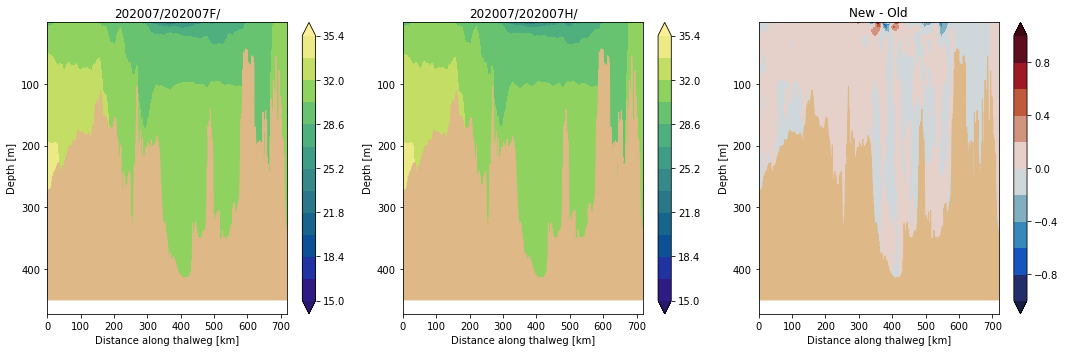

In [12]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Nitrate

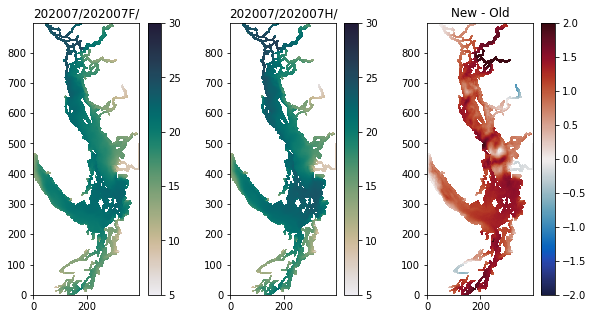

In [13]:
tracer = 'nitrate'
file = 'ptrc'
month = '01'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

28.952777691777026 30.124505293627685


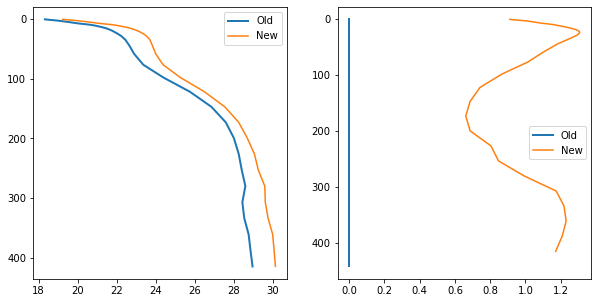

In [14]:
fig = profiles(tracer, file)

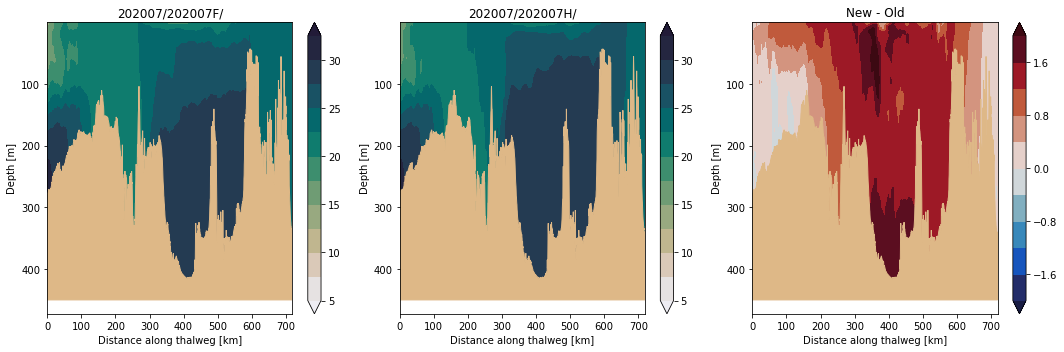

In [15]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Silicon

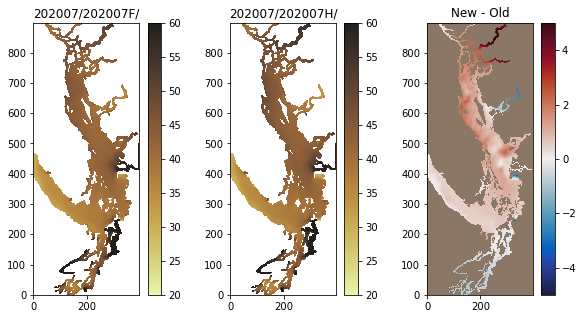

In [58]:
tracer = 'silicon'
file = 'ptrc'
month = '01'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

68.30571184716526 70.57607987191204


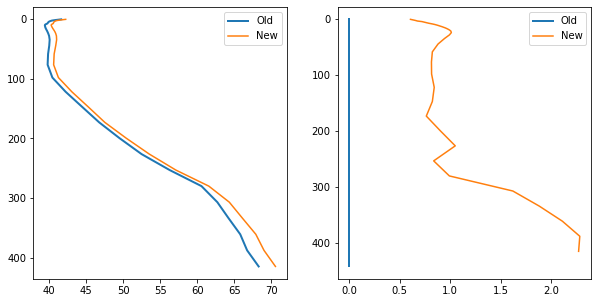

In [59]:
fig = profiles(tracer, file)

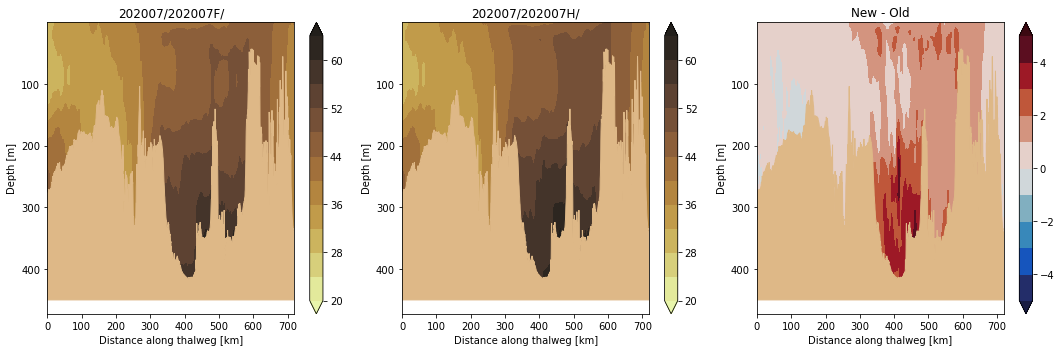

In [60]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Diatoms

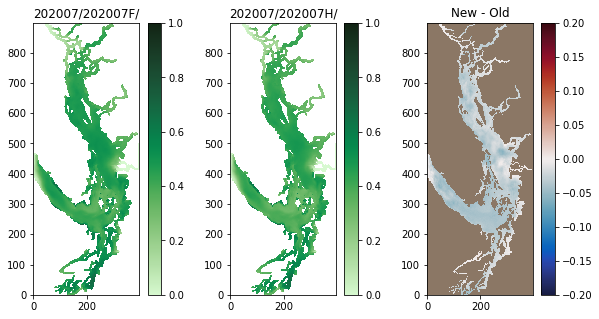

In [63]:
tracer = 'diatoms'
file = 'ptrc'
month = '01'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.4212131302053507 0.39292946919174687


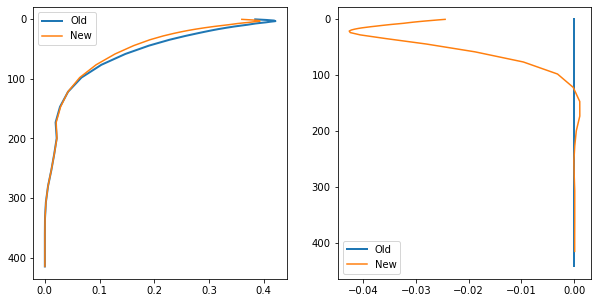

In [64]:
fig = profiles(tracer, file)

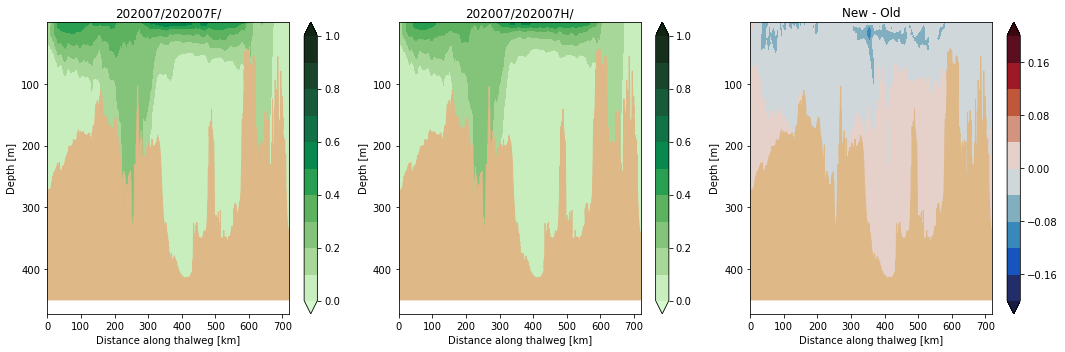

In [65]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## January: Flagellates

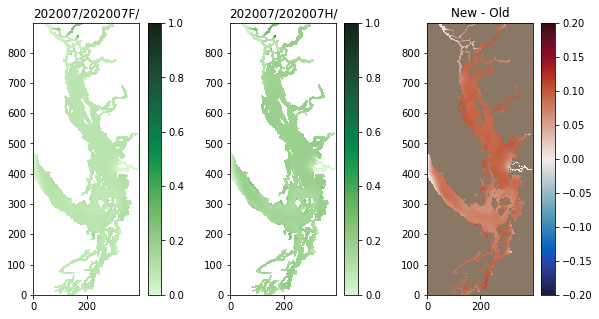

In [70]:
tracer = 'flagellates'
file = 'ptrc'
month = '01'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.08294959094983868 0.15652877154095135


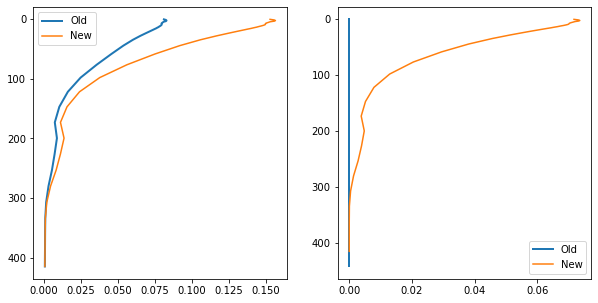

In [71]:
fig = profiles(tracer, file)

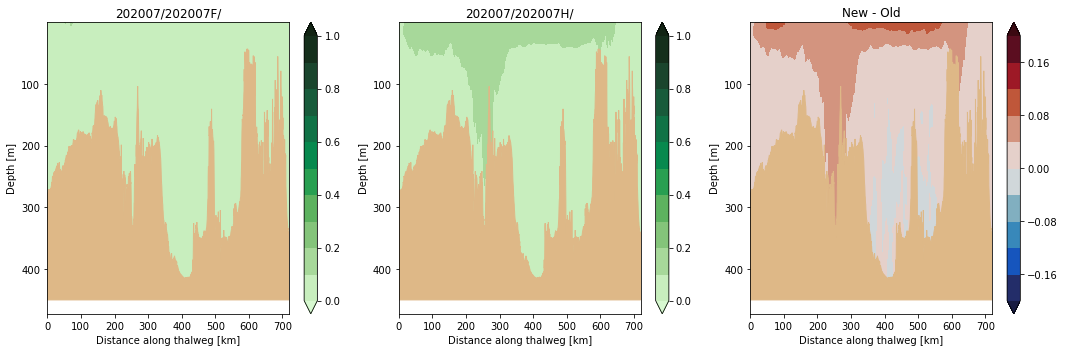

In [72]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## February: Nitrate

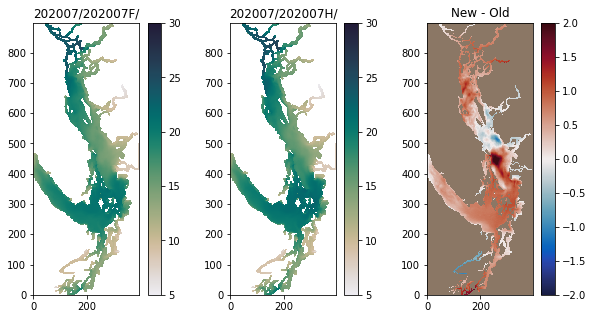

In [73]:
tracer = 'nitrate'
file = 'ptrc'
month = '02'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

29.11017812872508 30.23836727796795


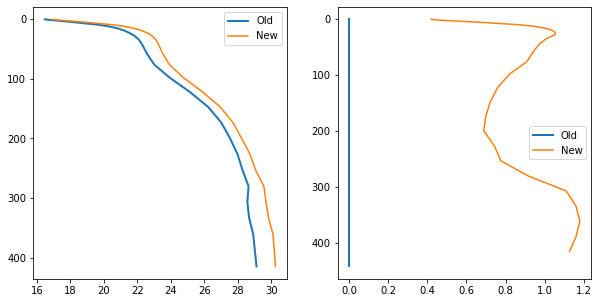

In [74]:
fig = profiles(tracer, file)

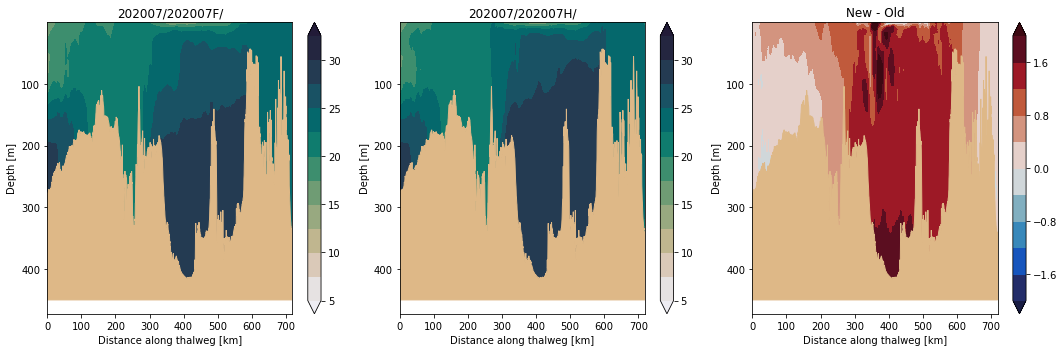

In [75]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## February: Flagellates

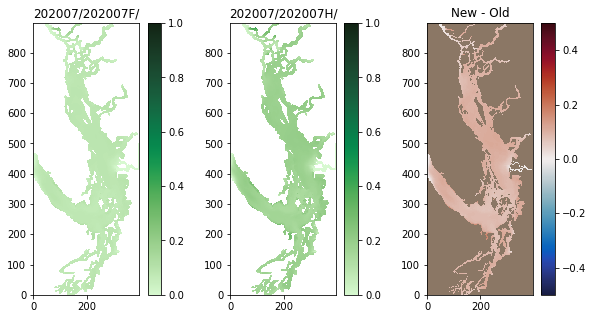

In [79]:
tracer = 'flagellates'
file = 'ptrc'
month = '02'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.0762965481636077 0.1636264972482205


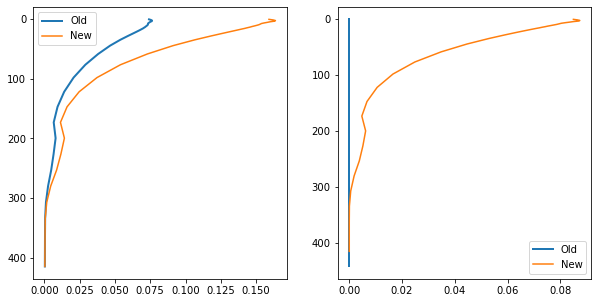

In [80]:
fig = profiles(tracer, file)

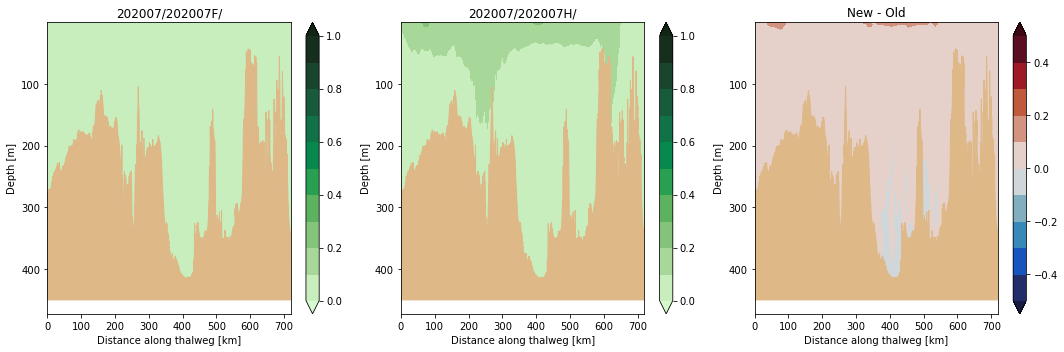

In [81]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Feb Flagellates compared to 201905

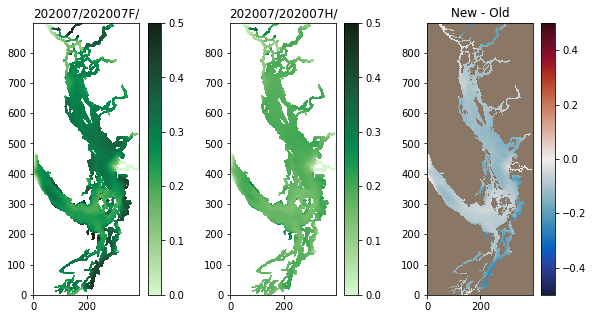

In [82]:
tracer = 'flagellates'
file = 'ptrc'
month = '02'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.5
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

0.2623085411812389 0.1636264972482205


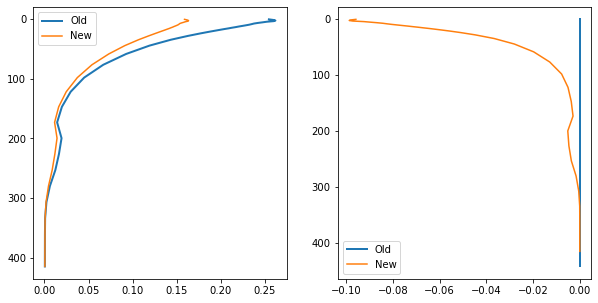

In [83]:
fig = profiles(tracer, file, d201905=True)

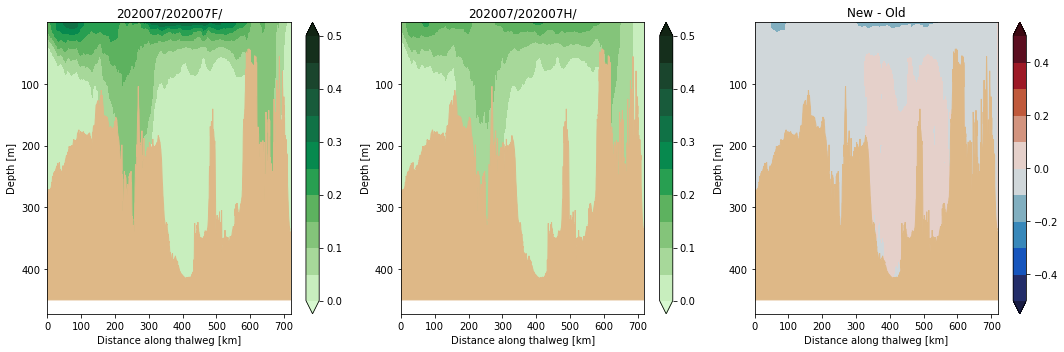

In [84]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

## February: Diatoms

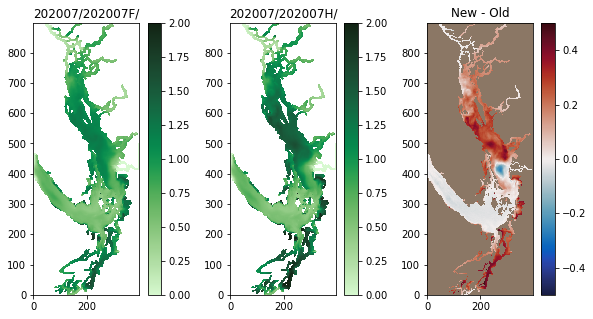

In [85]:
tracer = 'diatoms'
file = 'ptrc'
month = '02'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.8238066568956877 0.9229430987300078


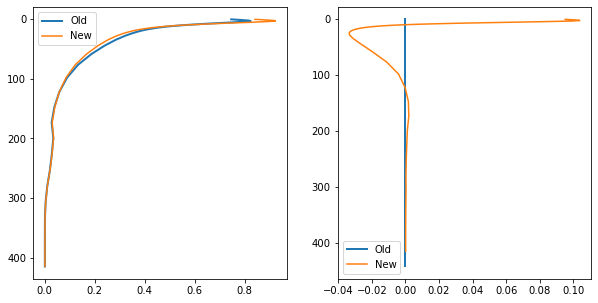

In [86]:
fig = profiles(tracer, file)

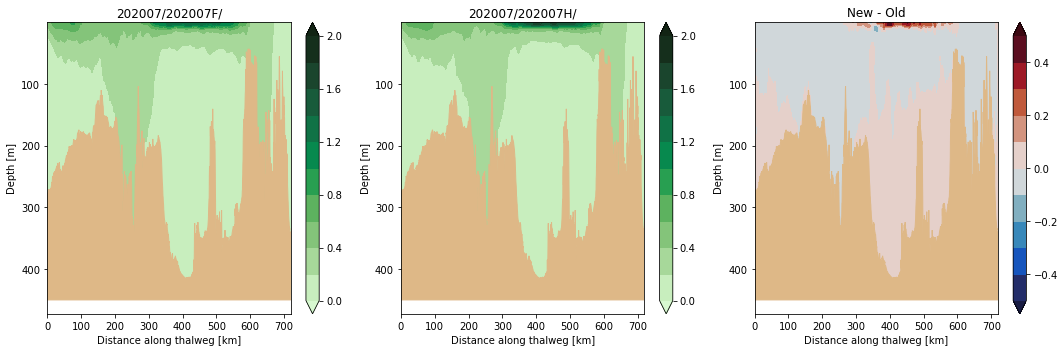

In [87]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## March: Diatoms

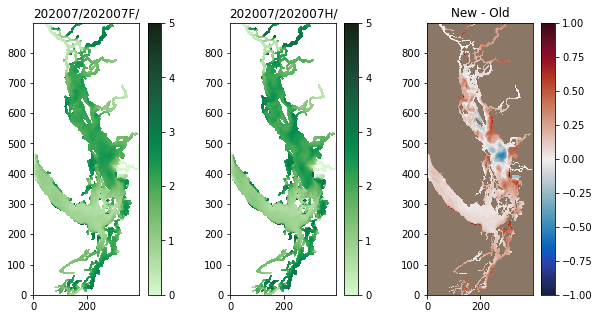

In [88]:
tracer = 'diatoms'
file = 'ptrc'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.5318727322544676 1.66043222194742


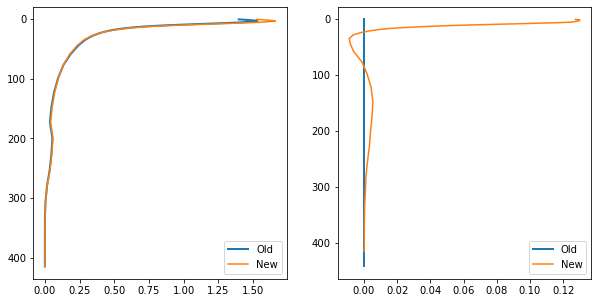

In [89]:
fig = profiles(tracer, file)

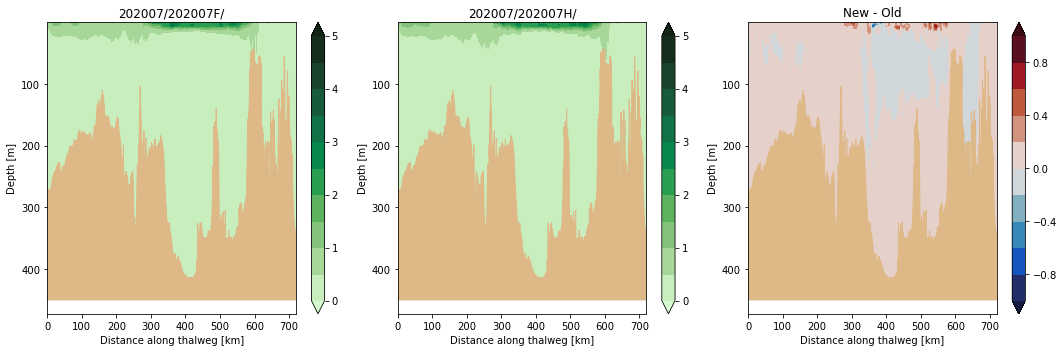

In [90]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## March: Flagellates

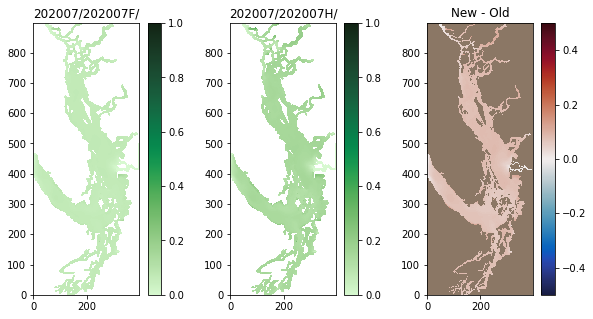

In [94]:
tracer = 'flagellates'
file = 'ptrc'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.06257440591107033 0.1319401291814032


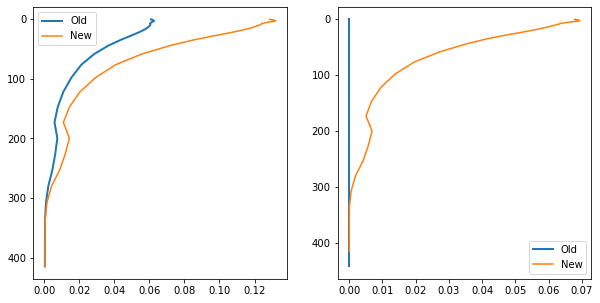

In [95]:
fig = profiles(tracer, file)

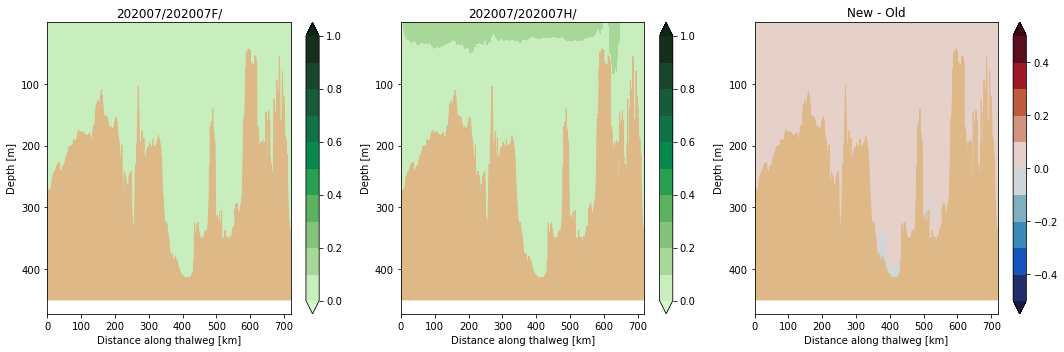

In [96]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

# April: Nitrate

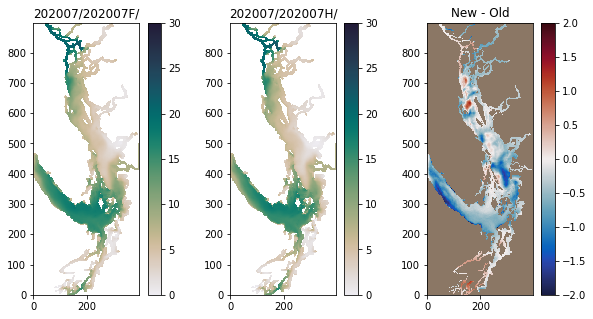

In [100]:
tracer = 'nitrate'
file = 'ptrc'
month = '04'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

29.36518252728952 30.40869651962621


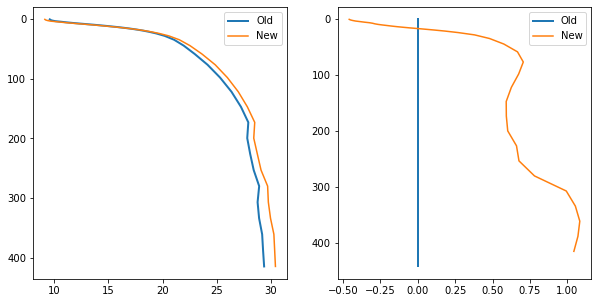

In [101]:
fig = profiles(tracer, file)

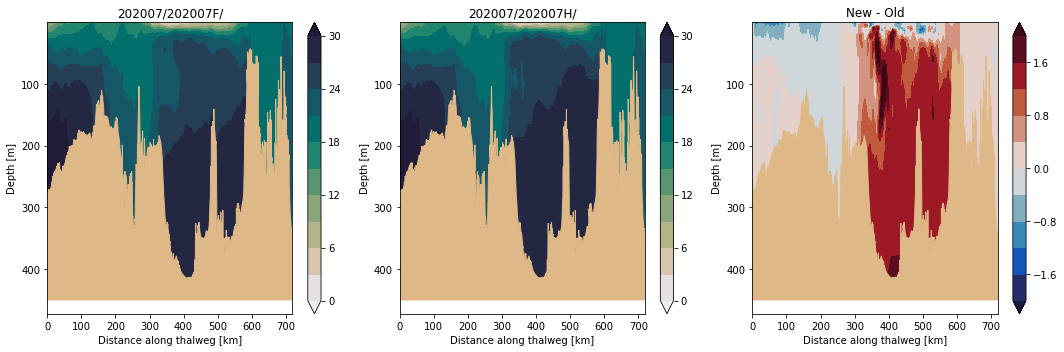

In [102]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

# April: Diatoms

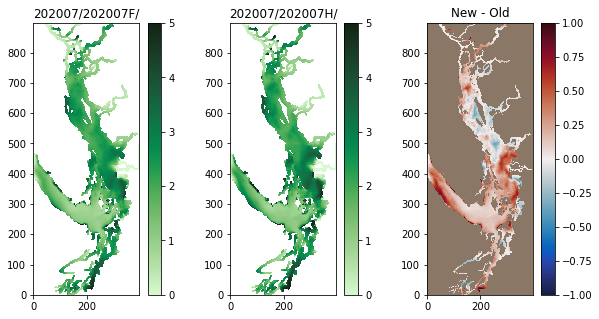

In [103]:
tracer = 'diatoms'
file = 'ptrc'
month = '04'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.7924170813030935 1.9471504330525644


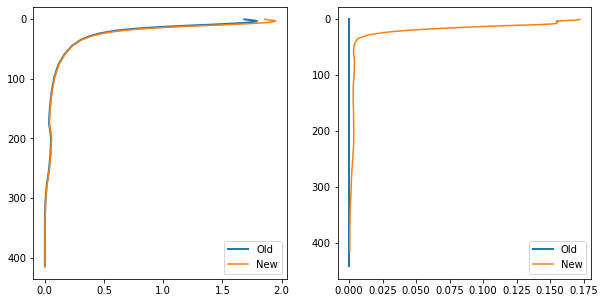

In [104]:
fig = profiles(tracer, file)

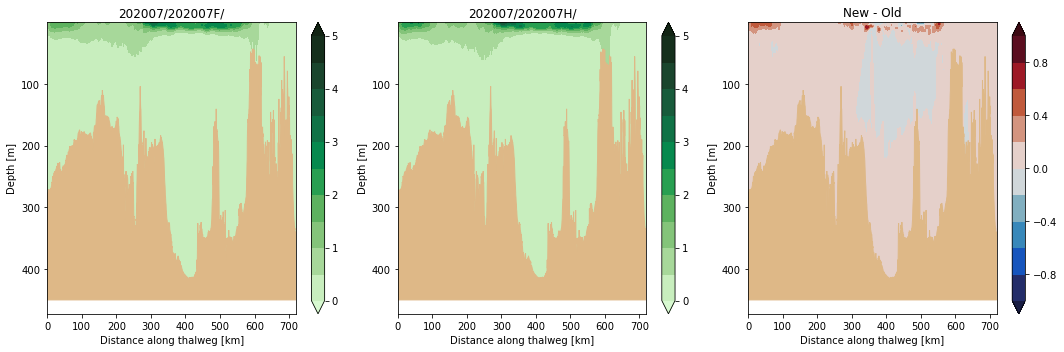

In [105]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

# April: Flagellates

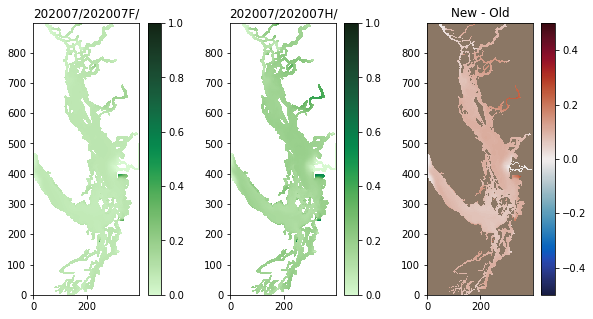

In [109]:
tracer = 'flagellates'
file = 'ptrc'
month = '04'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.0735430750197338 0.1581671663300721


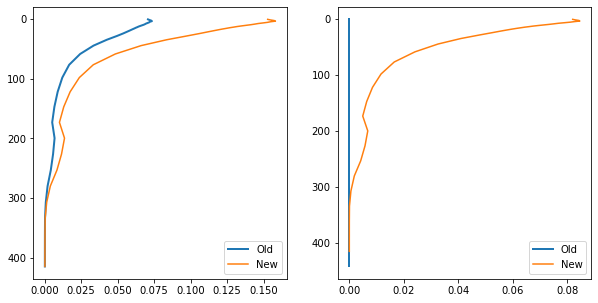

In [110]:
fig = profiles(tracer, file)

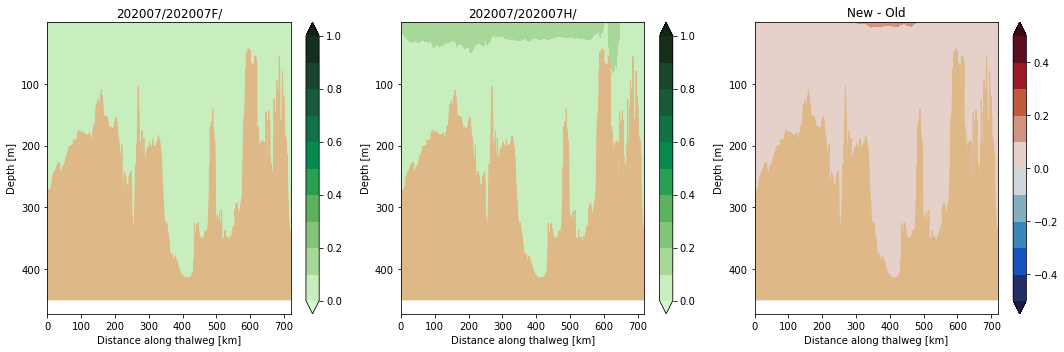

In [111]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## April: Microzooplankton

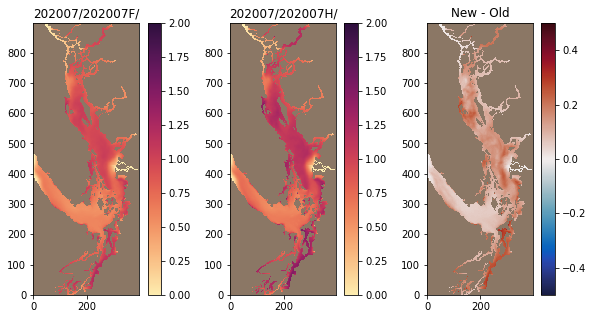

In [112]:
tracer = 'microzooplankton'
file = 'ptrc'
month = '04'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 2
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.7021891860164057 0.8133668547184065


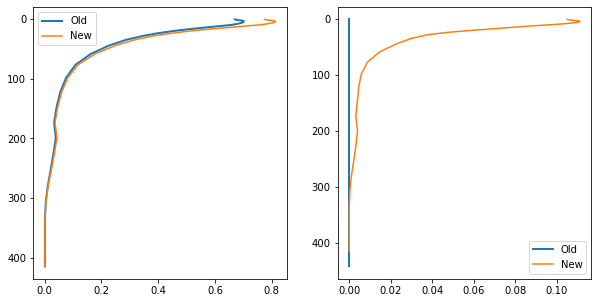

In [113]:
fig = profiles(tracer, file)

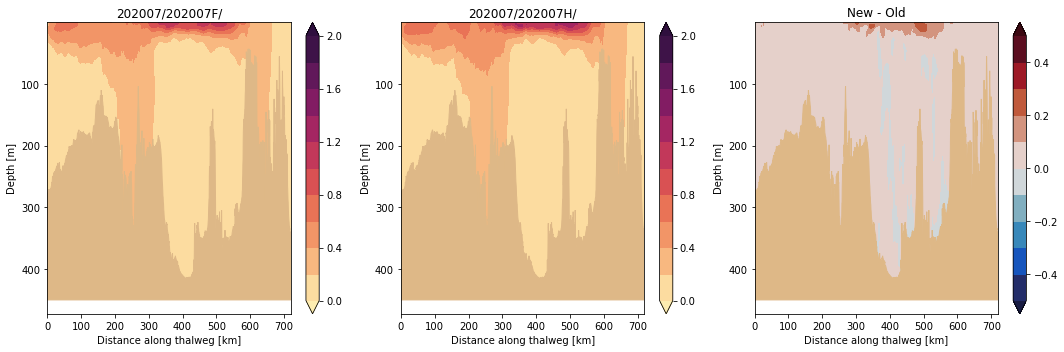

In [114]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

# ONLY TO HERE

## May: Salinity

In [ ]:
tracer = 'vosaline'
file = 'grid'
month = '05'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## May Diatoms

In [ ]:
tracer = 'diatoms'
file = 'ptrc'
month = '05'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## May Diatoms new compared to H201812

In [ ]:
tracer = 'diatoms'
file = 'ptrc'
month = '05'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

In [ ]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

## June: Flagellates

In [ ]:
tracer = 'flagellates'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### June: Flagellates compared to 201905

In [ ]:
tracer = 'flagellates'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

In [ ]:
fig = profiles(tracer, file, d201905=True)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, d201905=True)

## June Diatoms

In [ ]:
tracer = 'diatoms'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, maxdepth=50)

## June Diatoms against 201812 Hindcast

In [ ]:
tracer = 'diatoms'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

In [ ]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, 
                    olddir='averages/nowcast-green.201812/')

In [ ]:
newdir

## July : NH4

In [ ]:
tracer = 'ammonium'
file = 'ptrc'
month = '07'
cmap = cm.speed
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## July: Diatoms

In [ ]:
tracer = 'diatoms'
file = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### July: Nitrate

In [ ]:
tracer = 'nitrate'
file = 'ptrc'
month = '07'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### July: Silicon

In [ ]:
tracer = 'silicon'
file = 'ptrc'
month = '07'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 10
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## August: SSH

In [ ]:
tracer = 'sossheig'
file = 'grid'
month = '08'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.01
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True)

## September: PON

In [ ]:
tracer = 'particulate_organic_nitrogen'
file = 'ptrc'
month = '09'
cmap = cm.matter
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## October: dissolved Silicon

In [ ]:
tracer = 'silicon'
file = 'ptrc'
month = '10'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## November: DIC

In [ ]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
month = '11'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 50
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## November Nitrate

In [ ]:
tracer = 'nitrate'
file = 'ptrc'
month = '11'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
print (olddir)

## November Nitrate versus H201812

In [ ]:
tracer = 'nitrate'
file = 'ptrc'
month = '11'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

In [ ]:
fig = profiles(tracer, file, olddir='averages/nowcast-green.201812/')

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, olddir='averages/nowcast-green.201812/')

## December Alkalinity

In [ ]:
tracer = 'total_alkalinity'
file = 'carp'
month = '12'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

In [ ]:
fig = profiles(tracer, file)

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

## December Fraser Tracer

In [ ]:
tracer = 'Fraser_tracer'
file = 'carp'
month = '12'
cmap = cm.amp
cdiff = cm.balance
vmax = 6
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, dl=3,
                    zoom=[320, 500, 290, 398])

# Whole Year

In [ ]:
olddir = '202007/202007C-p2'
nextdir = '202007/202007D-again'
newdir = '202007/202007D-lowR'
nocdir = '202007/202007D-nociliates'
d201905 = 'averages/hindcast.201905'
d201812 = 'averages/nowcast-green.201812'
file = 'ptrc'
dosum = True
tracers = ['diatoms', 'flagellates', 'ciliates']
dl = 0
zoom=[0, 0, 0, 0]
cmap = 'gist_ncar'
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201812}/SalishSea_1y_{year}_{year}_{file}_T.nc')

if dosum:
    dm['summed'] = 0.*dm[tracers[0]]
    for tr in tracers:
        dm['summed'] = dm['summed'] + dm[tr]
    tracer = 'summed'
else:
    tracer = tracers

mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
axs[0].set_title(d201812)
fig.colorbar(colours, ax=axs[0])
dm.close()

dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201905}/SalishSea_1y_{year}_{year}_{file}_T.nc')

if dosum:
    dm['summed'] = 0.*dm[tracers[0]]
    for tr in tracers:
        dm['summed'] = dm['summed'] + dm[tr]
    tracer = 'summed'
else:
    tracer = tracers

mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
colours = axs[1].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
axs[1].set_title(d201905)
fig.colorbar(colours, ax=axs[1])
dm.close()

ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
    
if dosum:
    ds['summed'] = 0.*ds[tracers[0]]
    for tr in tracers:
        ds['summed'] = ds['summed'] + ds[tr]
    
    field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
colours = axs[2].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
axs[2].set_title(newdir)
fig.colorbar(colours, ax=axs[2])
ds.close()
    
for ax in axs:
    viz_tools.set_aspect(ax)
    if sum(zoom) > 0:
        ax.set_ylim(zoom[0], zoom[1])
        ax.set_xlim(zoom[2], zoom[3])

In [ ]:
do = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{nextdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
dc = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{nocdir}/SalishSea_1y_{year}_{year}_{file}_T.nc')
d8 = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201812}/SalishSea_1y_{year}_{year}_{file}_T.nc')
d9 = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{d201905}/SalishSea_1y_{year}_{year}_{file}_T.nc')

In [ ]:
imin, imax = 0, -1
jmin, jmax = 0, -1
print ('diatoms')
print (do.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('flagellates')
print (do.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('ciliates')
print (do.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)

In [ ]:
imin, imax = 350, 750
jmin, jmax = 100, 350
print ('diatoms')
print (do.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('flagellates')
print (do.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('ciliates')
print (do.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)

In [ ]:
print ('JdF')
imin, imax = 200, 500
jmin, jmax = 0, 200
print ('diatoms')
print (do.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.diatoms[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('flagellates')
print (do.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.flagellates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print ('ciliates')
print (do.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dm.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (ds.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (dc.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d8.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)
print (d9.ciliates[0, :, imin:imax, jmin:jmax].sum(axis=0).mean().values)

In [ ]:
3.6/7.9

In [ ]:
1.7/4.6

In [ ]:
8.2/12.9

In [ ]:
4.8/7.7

In [ ]:
3.8/6.6

In [ ]:
1.4/4.3

In [ ]:
3.9/6

In [ ]:
.7/6

In [ ]:
1.5/4.3

In [ ]:
1.4/6.6